<a href="https://colab.research.google.com/github/MarinaChau/AttaCoeurs/blob/main/Adversarial_Attacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project is about adversarial attacks.

## Outline of the project 


1.   Building a classifier on CIFAR-10
2.   Implementing various adversarial attacks
3.   Building adversarial training
4.   Comparing various adversarial training strategies with various attacks





## Importing modules and setting notebook parameters

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/MarinaChau/AttaCoeurs.git

Cloning into 'AttaCoeurs'...
remote: Enumerating objects: 167, done.
remote: Counting objects: 100% (163/163), done.
remote: Compressing objects: 100% (104/104), done.
remote: Total 167 (delta 73), reused 120 (delta 51), pack-reused 4
Receiving objects: 100% (167/167), 8.98 MiB | 34.33 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
%cd AttaCoeurs

/content/AttaCoeurs


In [ ]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from AttaCoeurs.src import adversarial_attacks as attacks
from AttaCoeurs.src import custom_model as models

# Building a simple CIFAR-10 classifier.

Here, we create a neural network for image classification on the CIFAR-10 dataset.
First, we download and instanciate the CIFAR-10 dataset.

In [ ]:
# Load Cifar dataset from keras
(x_train,y_train), (x_test,y_test) = tf.keras.datasets.cifar10.load_data()

# Preprocess
x_train = tf.constant(x_train.reshape(50000,32, 32,3).astype("float32") / 255)
x_test = tf.constant(x_test.reshape(10000, 32, 32, 3).astype("float32") / 255)

y_train = tf.constant(y_train.astype("float32"))
y_test = tf.constant(y_test.astype("float32"))

print(f"x_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


In [ ]:
rd_id = np.random.randint(len(x_test))

In [ ]:
# Parameters for the architecture of convolutional neural networks
class CnnParams(object):
    def __init__(self):
        # Model hyperparameters
        self.input_shape = [32, 32, 3]
        self.num_classes = 10
        self.num_conv_filters = [64, 64, 32, 32]
        self.kernel_size = (3, 3)
        self.pool_size = (2, 2)
        self.num_fc_units = [512]

        self.epochs = 40
        self.batch_size = 32
        
cnn_params = CnnParams()


def get_cnn_model(adv_training_with=None, name="cnn_model"):
    """
    Returns a CustomModel for adversarial training.
    """

    # Define Model layers
    inputs = tf.keras.Input(shape=cnn_params.input_shape,
                            dtype=tf.float32, name="image")

    x = inputs
    
    # Convolutional layer followed by MaxPool and Dropout regularization layers
    for i, num_filters in enumerate(cnn_params.num_conv_filters):
        x = tf.keras.layers.Conv2D(num_filters,
                                   cnn_params.kernel_size,
                                   padding='same',
                                   activation='relu',
                                   name=f"Conv{i}")(x)
        if i < len(cnn_params.num_conv_filters) - 1:
            # Max pooling + Dropout
            x = tf.keras.layers.MaxPooling2D(cnn_params.pool_size, name=f"MaxPool{i}")(x)
            x = tf.keras.layers.Dropout(0.25, name=f"Dropout{i}")(x)
    
    x = tf.keras.layers.Flatten()(x)

    for i, num_units in enumerate(cnn_params.num_fc_units):
        x = tf.keras.layers.Dense(num_units,
                                  activation='relu',
                                  name=f"Dense{i}")(x)

    pred = tf.keras.layers.Dense(cnn_params.num_classes, activation='softmax')(x)
    
    # CustomModel instanciates a Keras model.
    return models.CustomModel(inputs=inputs, 
                              outputs=pred, 
                              adv_training_with=adv_training_with,
                              name=name)

Building and compiling the model

In [ ]:
# Building model
model = get_cnn_model(adv_training_with=None, 
                      name="BaseModel")

# Compiling model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

Training without adversary examples. Code for training is commented, instead we load a pre_trained model from github.

In [ ]:
print(f"Building {model.name},{model.training_info}")

# Uncomment for training
# model.fit(x_train, y_train,
#           batch_size=cnn_params.batch_size,
#           epochs=cnn_params.epochs,
#           validation_data=(x_test, y_test)
#           )
model.load_weights("pre_train/BaseModel_40_epochs.h5")

Building BaseModel, trained without adversarial examples


Evaluating the model on clean test dataset.

In [ ]:
metrics = model.evaluate(x_test, y_test)
print("Accuracy : {:.3f}".format(metrics[1]))

313/313 [==============================] - 10s 3ms/step - loss: 0.6976 - acc: 0.7583
Accuracy : 0.758


# 3. Implementing adversarial attacks

## 3.1. FGSM

Setting parameter values

In [ ]:
eps_values = [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]
print(f"epsilon values : {eps_values}")

epsilon values : [0.005, 0.01, 0.02, 0.03, 0.05, 0.1, 0.2]


In [ ]:
fgsm_params = {"eps_values": eps_values}

In [ ]:
accuracies = []
for eps in eps_values:
  attack = attacks.Fgsm(model, eps=eps)
  x_corrupted = attack(x_test[:200], y_test[:200])
  
  acc = model.evaluate(x_corrupted, y_test[:200], verbose=False)
  print("eps = {:.3f} -- Accuracy : {:.3f}".format(eps, acc[1]))
  accuracies.append(acc[1])

eps = 0.005 -- Accuracy : 0.550
eps = 0.010 -- Accuracy : 0.355
eps = 0.020 -- Accuracy : 0.140
eps = 0.030 -- Accuracy : 0.085
eps = 0.050 -- Accuracy : 0.045
eps = 0.100 -- Accuracy : 0.050
eps = 0.200 -- Accuracy : 0.100


Text(0.5, 1.0, 'Hyperparameter search for FGSM attack')

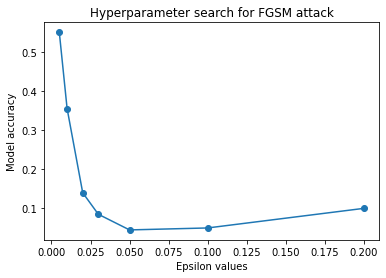

In [ ]:
plt.plot(eps_values, accuracies, marker="o")
plt.xlabel("Epsilon values")
plt.ylabel("Model accuracy")
plt.title("Hyperparameter search for FGSM attack")

We notice that $\epsilon = 0.05$ gives the best performances.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


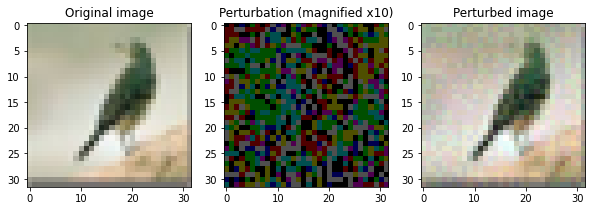

FGSM : The norm of the perturbation is 1.718


In [ ]:
rd_id = np.random.randint(len(x_test))
example = (x_test[rd_id:rd_id+1], y_test[rd_id:rd_id+1])
x = attacks.Fgsm(model, eps=0.031)(*example).numpy()
f, ax = plt.subplots(1,3, figsize=(10,10))
r_tot = x_test[rd_id] - x[0]
ax[0].imshow(x_test[rd_id])
ax[1].imshow(r_tot*10)
ax[2].imshow(x[0])

ax[0].set_title("Original image")
ax[1].set_title("Perturbation (magnified x10)")
ax[2].set_title("Perturbed image")

plt.show()

print("FGSM : The norm of the perturbation is {:.3f}".format(np.linalg.norm(r_tot)))

## 3.2. PGD

In [ ]:
pgd = attacks.PgdRandomRestart(model,
                              eps=0.031,
                              alpha=0.015,
                              num_iter=10,
                              restarts=10)
x_corrupted = pgd(x_test[:200], y_test[:200])
acc = model.evaluate(x_corrupted, y_test[:200], verbose=False)

print("Accuracy : {:.3f}".format(acc[1]))

Accuracy : 0.005


Visualizing PGD attacks

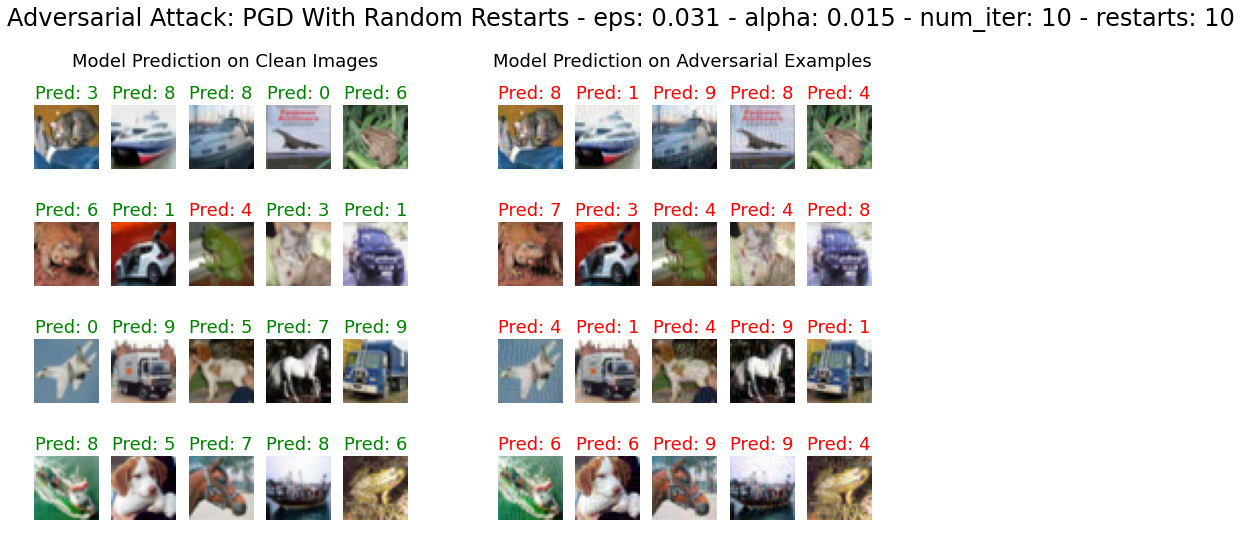

In [ ]:
attack_kwargs = {"eps": 0.031,
                 "alpha": 0.015,
                 "num_iter": 10,
                 "restarts": 10}
attacks.attack_visual_demo(model,
                           attacks.PgdRandomRestart,
                           attack_kwargs,
                           x_test[:20],
                           y_test[:20])

As we can see, the perturbations are somewhat hard to notice.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


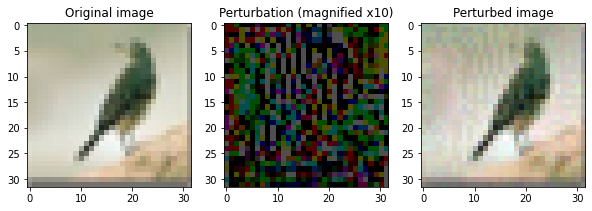

PGD : The norm of the perturbation is 1.497


In [ ]:
example = (x_test[rd_id:rd_id+1], y_test[rd_id:rd_id+1])
x = pgd(*example).numpy()
f, ax = plt.subplots(1,3, figsize=(10,10))
r_tot = x_test[rd_id] - x[0]
ax[0].imshow(x_test[rd_id])
ax[1].imshow(r_tot*10)
ax[2].imshow(x[0])

ax[0].set_title("Original image")
ax[1].set_title("Perturbation (magnified x10)")
ax[2].set_title("Perturbed image")

plt.show()

print("PGD : The norm of the perturbation is {:.3f}".format(np.linalg.norm(r_tot)))

## 3.3. DeepFool

DeepFool requires no hyperparameters. However, for practical concerns, we restrict the number of iterations to a fixed value.

In [ ]:
deepfool = attacks.DeepFool(model, num_iter=50)
x_corrupted = deepfool(x_test[:20], y_test[:20])
acc = model.evaluate(x_corrupted, y_test[:20], verbose=False)

print("Accuracy : {:.3f}".format(acc[1]))

Accuracy : 0.050


Visualizing DeepFool attacks

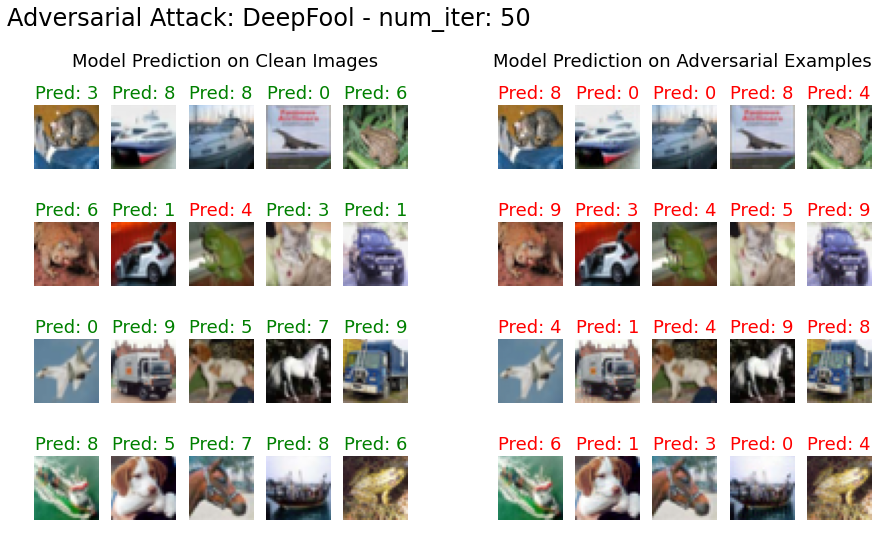

In [ ]:
attack_kwargs = {"num_iter": 50}
attacks.attack_visual_demo(model,
                           attacks.DeepFool,
                           attack_kwargs,
                           x_test[:20],
                           y_test[:20])

As we can see, the perturbations are very hard to notice.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


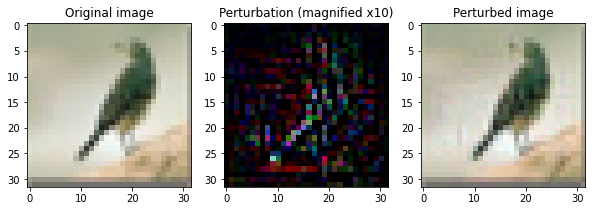

DeepFool : The norm of the perturbation is 0.963


In [ ]:
example = (x_test[rd_id], y_test[rd_id])
x, r_tot = deepfool.fool(*example)
f, ax = plt.subplots(1,3, figsize=(10,10))
ax[0].imshow(x_test[rd_id])
ax[1].imshow(r_tot*10)
ax[2].imshow(x)

ax[0].set_title("Original image")
ax[1].set_title("Perturbation (magnified x10)")
ax[2].set_title("Perturbed image")

plt.show()

print("DeepFool : The norm of the perturbation is {:.3f}".format(np.linalg.norm(r_tot)))

## 3.4 AutoPGD

In [ ]:
apgd = attacks.APGD(model,
                    eps=8/255,
                    alpha=0.075,
                    num_iter=50,
                    norm='Linf')
x_corrupted = apgd(x_test[:20], y_test[:20])
acc = model.evaluate(x_corrupted, y_test[:20], verbose=False)

print("Accuracy : {:.3f}".format(acc[1]))

Accuracy : 0.100


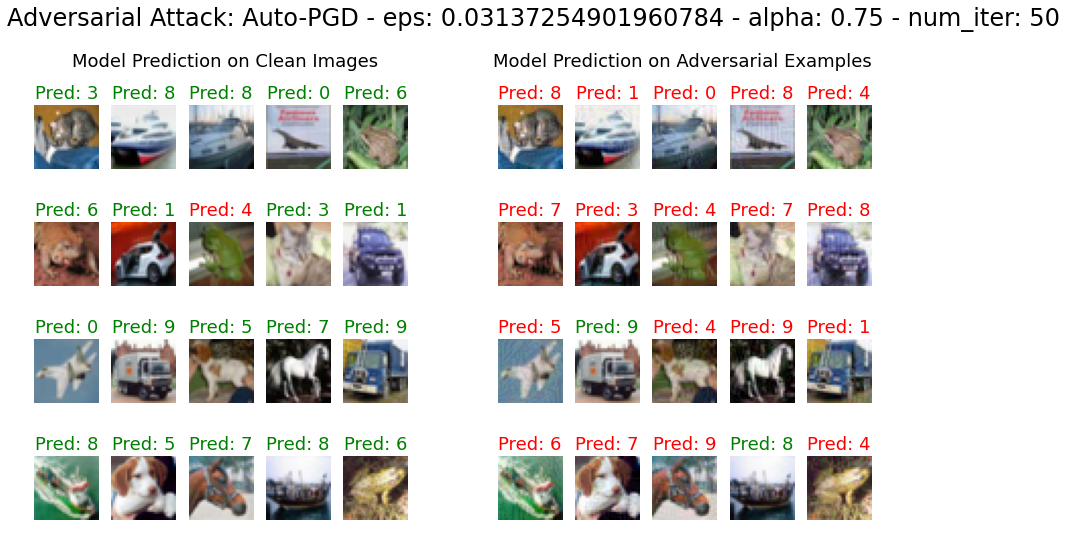

In [ ]:
attack_kwargs = {"eps": 8/255,
                 "alpha": 0.75,
                 "num_iter": 50,
                 "norm": 'Linf'}
attacks.attack_visual_demo(model,
                           attacks.APGD,
                           attack_kwargs,
                           x_test[:20],
                           y_test[:20])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


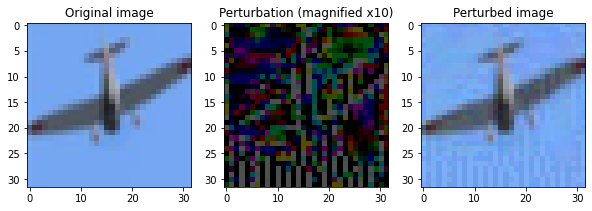

AutoPGD : The norm of the perturbation is 1.430


In [ ]:
rd_id = np.random.randint(len(x_test))
example = (x_test[rd_id:rd_id+1], y_test[rd_id:rd_id+1])
x = apgd(*example)
f, ax = plt.subplots(1,3, figsize=(10,10))
r_tot = x_test[rd_id] - x[0]
ax[0].imshow(x_test[rd_id])
ax[1].imshow(r_tot*10)
ax[2].imshow(x[0])

ax[0].set_title("Original image")
ax[1].set_title("Perturbation (magnified x10)")
ax[2].set_title("Perturbed image")

plt.show()

print("AutoPGD : The norm of the perturbation is {:.3f}".format(np.linalg.norm(r_tot)))

# 4. Adversarial Training

The goal of adversarial training is to try to build models that are more robust against adversarial attacks. In order to perform adversarial training, one adds adversarial examples to the training process to inform the neural network that classification should be invariant inside a ball of fixed radius.

## 4.1. Adversarial training with PGD

In [ ]:
# Set adversarial training parameters
attack_kwargs = {"eps": 0.031, 
                 "alpha": 0.015,
                 "num_iter": 5,
                 "restarts": 5}

adv_training_with = {"attack": attacks.PgdRandomRestart,
                     "attack kwargs": attack_kwargs}

# Build model
cnn_model_pgd = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_pgd.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
cnn_model_pgd.run_eagerly = True

# Train model
# cnn_model_pgd.fit(x_train, y_train,
#                    batch_size=16,epochs=20,
#                    validation_split=0.2)

In [ ]:
cnn_model_pgd.load_weights("pre_train/PGD_adv_training_10_epochs.h5")

We analyse the test accuracy of the adversarially trained classifier.

In [ ]:
cnn_model_pgd.evaluate(x_test, y_test)

313/313 [==============================] - 3s 11ms/step - loss: 1.0617 - acc: 0.6288


[1.061726689338684, 0.6287999749183655]

## 4.1. Adversarial training with DeepFool

In [ ]:
# Set adversarial training parameters
attack_kwargs = {"num_iter": 40}

adv_training_with = {"attack": attacks.DeepFool,
                     "attack kwargs": attack_kwargs}

# Build model
cnn_model_deepfool = get_cnn_model(adv_training_with=adv_training_with)

# Compile model
cnn_model_deepfool.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])
cnn_model_deepfool.run_eagerly = True

cnn_model_deepfool.load_weights("pre_train/DeepFool_adv_training_17_epochs.h5")

# Train model
# cnn_model_deepfool.fit(x_train[::8], y_train[::8],
#                    batch_size=16,epochs=10,
#                    validation_split=0.2)

In [ ]:
cnn_model_deepfool.save_weights("pre_train/DeepFool_adv_training_20_epochs.h5")

# Analysing adversarial training against various attacks

## No adversarial training

We evaluate no adversarial training against the following attacks : 


*   FGSM
*   PGD with random restarts
*   Auto-PGD
*   DeepFool



In [ ]:
!pip install foolbox

In [ ]:
import foolbox
from foolbox.attacks import LinfPGD, L2DeepFoolAttack, BoundaryAttack, LinfFastGradientAttack

In [ ]:
# Instanciate model
base_model = get_cnn_model(name="BaseModel")

# Load model weights
base_model.load_weights("pre_train/BaseModel_40_epochs.h5")

# Compile model
base_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

fmodel = foolbox.models.TensorFlowModel(base_model, bounds=(0,1))

attack_dict = {"fgsm": LinfFastGradientAttack(),
               "pgd": LinfPGD(),
               "deepfool": L2DeepFoolAttack()}

y_test_values = tf.cast(tf.squeeze(y_test), "int32")

for attack_name, attack in attack_dict.items():
  print(f"Attacking {base_model.name} with {attack_name}...")
  x_corrupted, _, _ = attack(fmodel, x_test[:100], y_test_values[:100], epsilons=[0.031])
  acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
  print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {base_model.name} with CustomDeepFool...")
df = attacks.DeepFool(base_model, num_iter=50)
x_corrupted = df(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {base_model.name} with AutoPGD...")
apgd = attacks.APGD(base_model, eps=8/255, alpha=0.075, num_iter=50, norm='Linf' )
x_corrupted = apgd(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

Attacking BaseModel with fgsm...
    Test accuracy : 0.100
Attacking BaseModel with pgd...
    Test accuracy : 0.010
Attacking BaseModel with deepfool...
    Test accuracy : 0.000
Attacking BaseModel with CustomDeepFool...
    Test accuracy : 0.070
Attacking BaseModel with AutoPGD...
    Test accuracy : 0.150


## PGD Training

We evaluate PGD adversarial training against the following attacks : 


*   FGSM
*   PGD with random restarts
*   Auto-PGD
*   DeepFool



In [ ]:
# Instanciate model
pgd_model = get_cnn_model(name="AdversarialPGD")

# Load model weights
pgd_model.load_weights("pre_train/PGD_adv_training_10_epochs.h5")

# Compile model
pgd_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

fmodel = foolbox.models.TensorFlowModel(pgd_model, bounds=(0,1))

attack_dict = {"fgsm": LinfFastGradientAttack(),
               "pgd": LinfPGD(),
               "deepfool": L2DeepFoolAttack()}

y_test_values = tf.cast(tf.squeeze(y_test), "int32")

for attack_name, attack in attack_dict.items():
  print(f"Attacking {pgd_model.name} with {attack_name}...")
  x_corrupted, _, _ = attack(fmodel, x_test[:100], y_test_values[:100], epsilons=[0.031])
  acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
  print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {pgd_model.name} with CustomDeepFool...")
df = attacks.DeepFool(pgd_model, num_iter=50)
x_corrupted = df(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {pgd_model.name} with AutoPGD...")
apgd = attacks.APGD(pgd_model, eps=8/255, alpha=0.075, num_iter=50, norm='Linf' )
x_corrupted = apgd(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

Attacking AdversarialPGD with fgsm...
    Test accuracy : 0.450
Attacking AdversarialPGD with pgd...
    Test accuracy : 0.420
Attacking AdversarialPGD with deepfool...
    Test accuracy : 0.700
Attacking AdversarialPGD with CustomDeepFool...
    Test accuracy : 0.720
Attacking AdversarialPGD with AutoPGD...
    Test accuracy : 0.390


## DeepFool Training

We evaluate DeepFool adversarial training against the following attacks : 


*   FGSM
*   PGD with random restarts
*   Auto-PGD
*   DeepFool



In [ ]:
# Instanciate model
df_model = get_cnn_model(name="AdversarialDeepFool")

# Load model weights
df_model.load_weights("pre_train/DeepFool_adv_training_17_epochs.h5")

# Compile model
df_model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-06),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

fmodel = foolbox.models.TensorFlowModel(df_model, bounds=(0,1))

attack_dict = {"fgsm": LinfFastGradientAttack(),
               "pgd": LinfPGD(),
               "deepfool": L2DeepFoolAttack()}

y_test_values = tf.cast(tf.squeeze(y_test), "int32")

for attack_name, attack in attack_dict.items():
  print(f"Attacking {df_model.name} with {attack_name}...")
  x_corrupted, _, _ = attack(fmodel, x_test[:100], y_test_values[:100], epsilons=[0.031])
  acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
  print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {df_model.name} with CustomDeepFool...")
df = attacks.DeepFool(df_model, num_iter=50)
x_corrupted = df(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

print(f"Attacking {df_model.name} with AutoPGD...")
apgd = attacks.APGD(df_model, eps=8/255, alpha=0.075, num_iter=50, norm='Linf' )
x_corrupted = apgd(x_test[:100], y_test_values[:100])
acc = base_model.evaluate(x_corrupted, y_test[:100], verbose=False)
print("    Test accuracy : {:.3f}".format(acc[1]))

Attacking AdversarialDeepFool with fgsm...
    Test accuracy : 0.540
Attacking AdversarialDeepFool with pgd...
    Test accuracy : 0.540
Attacking AdversarialDeepFool with deepfool...
    Test accuracy : 0.730
Attacking AdversarialDeepFool with CustomDeepFool...
    Test accuracy : 0.650
Attacking AdversarialDeepFool with AutoPGD...
    Test accuracy : 0.540


# Evaluating the norm of the perturbation

In [ ]:
attack_dict = {"fgsm": attacks.Fgsm(model, eps=0.031),
               "pgd": attacks.PgdRandomRestart(model, eps=0.031, alpha=0.5, num_iter=10, restarts=10),
               "deepfool": attacks.DeepFool(model, num_iter=50),
               "autopgd": attacks.APGD(model, eps=8/255, alpha=0.075, num_iter=50, norm='Linf' )}

for attack_name, attack in attack_dict.items():
  print(f"Attacking {model.name} with {attack_name}...")
  x_corrupted = attack(x_test[:101], y_test[:101])
  perturbations = np.array(x_test[:101]) - np.array(x_corrupted)
  norms = [np.linalg.norm(x) for x in perturbations]
  avg_norm = np.mean(norms)
  print("    Average perturbation norm : {:.3f}".format(avg_norm))

Attacking BaseModel with fgsm...
    Average perturbation norm : 1.703
Attacking BaseModel with pgd...
    Average perturbation norm : 1.703
Attacking BaseModel with deepfool...
    Average perturbation norm : 0.426
Attacking BaseModel with autopgd...
    Average perturbation norm : 1.321
